# Batch Normalization

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/fitter-happier-models/blob/master/docs/notebooks/language-modeling/03-batchnorm.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/fitter-happier-models?style=social)](https://github.com/particle1331/fitter-happier-models)

---

## Introduction

In this notebook, we dive into some of the internals of MLPs with multiple layers and scrutinize the statistics of the forward pass activations, backward pass gradients, and some of the pitfalls when they are improperly scaled. We also look at the typical diagnostic tools and visualizations that you would want to use to understand the health of your deep network. We learn why training deep neural nets can be fragile and introduce the first modern innovation that made training deep networks so much easier: **Batch Normalization** {cite}`batchnorm`. Residual connections {cite}`resnet` and the Adam optimizer {cite}`adam` remain notable todos for later notebooks. This notebook is based on the lecture {cite}`makemore3`.

## Preliminaries

For our experiments, we will use the model from our previous notebook.

In [1]:
import torch
import torch.nn.functional as F

import math
import warnings
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib_inline import backend_inline

DATASET_DIR = Path("./data").absolute()
RANDOM_SEED = 9000
GENERATOR = torch.Generator().manual_seed(RANDOM_SEED)
get_generator = lambda g: GENERATOR if g is None else g

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats('svg')

Still using the names dataset:

In [2]:
names = open(DATASET_DIR / 'names.txt', 'r').read().splitlines()

print(len(names))
names[:5]

32033


['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
class CharDataset:
    def __init__(self, names, block_size):
        self.names = names
        self.vocab = ['.'] + sorted(list(set(''.join(names))))
        self.block_size = block_size
        self.itos = dict(enumerate(self.vocab))
        self.stoi = {c: i for i, c in self.itos.items()}

    def decode(self, x):
        return ''.join(self.itos[i] for i in x)

    def encode(self, word):
        return [self.stoi[c] for c in word]

    def build_dataset(self):
        """Creating subsequences -> next character target."""
        xs = []
        ys = []
        for name in self.names:
            context = ['.'] * self.block_size
            for c in name + '.':
                xs.append(self.encode(''.join(context)))
                ys.append(self.stoi[c])
                context = context[1:] + [c]
        
        return torch.tensor(xs), torch.tensor(ys)

Initializing our sequence dataset. Here we use the last three characters to predict the next character in a name:

In [4]:
import pandas as pd

dataset = CharDataset(names, block_size=3)
itos = dataset.itos
stoi = dataset.stoi

xs, ys = dataset.build_dataset()

df = pd.DataFrame({'xs': xs.tolist(), 'ys': ys.tolist()})
df['seq'] = df['xs'].apply(lambda x: ''.join(itos[c] for c in x))
df['target'] = df['ys'].map(itos)
df.head(5)

,xs,ys,seq,target
0,"[0, 0, 0]",5,...,e
1,"[0, 0, 5]",13,..e,m
2,"[0, 5, 13]",13,.em,m
3,"[5, 13, 13]",1,emm,a
4,"[13, 13, 1]",0,mma,.


We take our previous character-based language model that passes embeddings to an MLP. Note that we introduce a new parameter `training=False` in the `__call__` method to indicate the model call is done during training. Also, for linear layers, we introduce a function of layer shape to control the standard deviation of the weights. This will make sense later.

In [5]:
class MLP:
    def __init__(self, 
            embedding_size: int, 
            width: int, 
            block_size: int, 
            vocab_size=27,
            scale_hidden=lambda fan_in, fan_out: 1.0,
            scale_logits=lambda fan_in, fan_out: 1.0,            
            generator=None
        ):

        self.embedding_size = embedding_size
        self.width = width
        self.vocab_size = vocab_size
        
        self.g  = get_generator(generator)
        self.C  = torch.randn(vocab_size, embedding_size,           generator=self.g)
        self.W1 = torch.randn((block_size * embedding_size, width), generator=self.g) * scale_hidden(block_size * embedding_size, width)
        self.b1 = torch.randn(width,                                generator=self.g) 
        self.W2 = torch.randn((width, vocab_size),                  generator=self.g) * scale_logits(width, vocab_size)
        self.b2 = torch.randn(vocab_size,                           generator=self.g)

        for _, p in self.parameters():
            p.requires_grad = True

    def parameters(self):
        return [("C", self.C), ("W1", self.W1), ("b1", self.b1), ("W2", self.W2), ("b2", self.b2)]

    def __call__(self, x, training=False):
        emb     = self.C[x].view(-1, x.shape[1] * self.embedding_size)
        h       = emb @ self.W1 + self.b1
        h_act   = torch.tanh(h)
        logits  = h_act @ self.W2 + self.b2

        self.out = {
            "emb": emb,
            "h": h,
            "h_act": h_act,
            "logits": logits
        }
                
        return logits

    def zero_grad(self):
        for _, p in self.parameters():
           p.grad = None

Defining helper functions for training and evaluation. Note that in `train_step` we call the model with `training=True` (only do this in the context of updating model weights).

In [6]:
from sklearn.model_selection import StratifiedKFold

def create_folds(xs, ys, seed=RANDOM_SEED):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    folds = torch.zeros(xs.shape[0])
    for fold, (trn_, val_) in enumerate(kf.split(xs, ys)):
        folds[val_] = fold

    x_train, y_train = xs[folds >  1], ys[folds >  1]
    x_valid, y_valid = xs[folds == 1], ys[folds == 1]
    x_test,  y_test  = xs[folds == 0], ys[folds == 0]

    return x_train, y_train, x_valid, y_valid, x_test, y_test


class Engine:
    def __init__(self,
            x_train, y_train,
            x_valid, y_valid,
            batch_size=32,
            generator=None
        ):
        self.x_train = x_train
        self.y_train = y_train
        self.x_valid = x_valid
        self.y_valid = y_valid
        self.g = get_generator(generator)
        self.batch_size = batch_size


    def run(self, model, num_steps, *, lr=0.1, verbose=True, lr_find=False, **kwargs):
        """Run training with given no. of optim steps."""

        if lr_find:
            lr0 = self.lr_finder(model, **kwargs)
            print(f"Setting learning rate to {lr0:.2e}")
            lr = lr0

        self._lr_counter = 0
        self._best_valid_loss = float("inf")
        loss_train = {}
        loss_valid = {}

        for k in range(num_steps):
            x, y = self.sample_batch()
            loss = self.train_step(model, x, y, lr=lr)
            loss_train[k] = loss
            
            if (k % (num_steps // self.batch_size) == 0) or (k == num_steps - 1):
                loss_val = self.evaluate(model)
                loss_valid[k] = loss_val
                lr = self.lr_step(lr, loss_val, verbose)
                if verbose:
                    print(f"[{k+1:>0{int(len(str(num_steps)))}d}/{num_steps}]      loss={loss:<8.4f}    loss_val={loss_val:.4f}")

        return {
            "loss_train": loss_train,
            "loss_valid": loss_valid
        }


    def lr_finder(self, model, lre_min=-3, lre_max=0, plot=False, color='C0'):
        """Finding a good base learning rate for training."""

        # Training loss at each step
        num_steps = 1000
        lre = torch.linspace(lre_min, lre_max, num_steps)
        lrs = 10 ** lre
        
        losses = []
        for k in range(num_steps):
            x, y = self.sample_batch()
            loss = self.train_step(model, x, y, lr=lrs[k])
            losses.append(loss)

        # Moving average of previous losses
        w = num_steps // 20    # i.e. 1/2 (num_steps // 10)
        loss_ma = []
        for i in range(w, num_steps - w):
            loss_ma.append((lre[i], sum(losses[i-w: i+w]) / (2 * w)))

        # Minimum of MA curve as best learning rate
        best_lre = min(loss_ma, key=lambda x: x[1])[0]
        assert lre_min < best_lre < lre_max

        # Plotting
        if plot:
            plt.figure(figsize=(5, 2.5))
            plt.plot(lre, torch.tensor(losses).numpy(), alpha=0.2, color=color)
            plt.ylabel('loss')
            plt.xlabel('lr exponent')
            plt.plot([l[0] for l in loss_ma], [l[1] for l in loss_ma], color=color)
            plt.axvline(best_lre, linestyle='dashed', linewidth=1.2, color='black', zorder=-1)

        return 10 ** best_lre.item()


    def optim_step(self, model, lr):
        for _, p in model.parameters():
            p.data -= lr * p.grad


    def train_step(self, model, x, y, lr):
        """One step of backward pass and weight update."""
        loss = F.cross_entropy(model(x), target=y)
        
        model.zero_grad()        
        loss.backward()
        self.optim_step(model, lr=lr)
        
        return loss.item()


    @torch.no_grad()
    def evaluate(self, model, split='valid'):
        x, y = {
            'train': (self.x_train, self.y_train),
            'valid': (self.x_valid, self.y_valid)
        }[split]
        loss = F.cross_entropy(model(x), y)
        return loss.item()


    def sample_batch(self):
        B = torch.randint(
            0, self.x_train.shape[0], 
            (self.batch_size,), 
            generator=self.g
        )     
        x = self.x_train[B]
        y = self.y_train[B]
        return x, y


    def lr_step(self, lr, loss_valid, verbose):
        if loss_valid < self._best_valid_loss:
            self._best_valid_loss = loss_valid
            self._lr_counter = 0
        else:
            self._lr_counter += 1
            if self._lr_counter == 3:
                lr *= 0.1
                self._lr_counter = 0
                if verbose:
                    print(f"Decreasing learning rate to {lr:.2e}")
        return lr

Reproducing results from previous notebook:

In [7]:
x_train, y_train, x_valid, y_valid, x_test,  y_test = create_folds(xs, ys)

print(f"train: {len(x_train):>6}")
print(f"valid: {len(x_valid):>6}")
print(f"test:  {len(x_test):>6}\n")

trainer = Engine(
    x_train, y_train,
    x_valid, y_valid,
    batch_size=32,
)

model = MLP(embedding_size=10, width=200, block_size=3)
hist = trainer.run(model, 200000, lr_find=True, verbose=True)

train: 182516
valid:  22815
test:   22815

Setting learning rate to 2.11e-01
[000001/200000]      loss=15.3183     loss_val=12.4176
[006251/200000]      loss=2.9544      loss_val=2.6950
[012501/200000]      loss=2.4831      loss_val=2.6647
[018751/200000]      loss=2.9285      loss_val=2.5402
[025001/200000]      loss=2.6699      loss_val=2.6332
[031251/200000]      loss=2.3710      loss_val=2.6827
Decreasing learning rate to 2.11e-02
[037501/200000]      loss=2.2866      loss_val=2.6386
[043751/200000]      loss=2.3199      loss_val=2.1967
[050001/200000]      loss=1.9981      loss_val=2.1988
[056251/200000]      loss=2.2217      loss_val=2.1960
[062501/200000]      loss=2.4298      loss_val=2.1851
[068751/200000]      loss=2.1671      loss_val=2.1884
[075001/200000]      loss=2.7142      loss_val=2.1800
[081251/200000]      loss=2.1194      loss_val=2.1854
[087501/200000]      loss=2.0505      loss_val=2.1792
[093751/200000]      loss=2.4574      loss_val=2.1851
[100001/200000]      

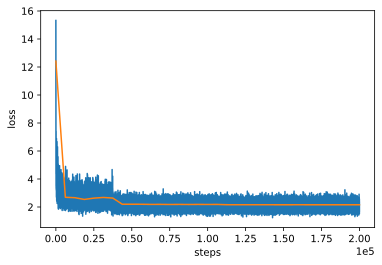

In [8]:
def plot_training_results(hist):
    plt.plot(hist['loss_train'].keys(), torch.tensor(list(hist['loss_train'].values())))
    plt.plot(hist['loss_valid'].keys(), torch.tensor(list(hist['loss_valid'].values())))
    plt.xlabel("steps")
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    plt.ylabel("loss");

plot_training_results(hist)

We will be keeping a results dict for monitoring our progress:

In [9]:
# dict for monitoring incremental progress
results = {}

def update_results(trainer, message):
    results[message] = {
        'train': trainer.evaluate(model, 'train'), 
        'valid': trainer.evaluate(model, 'valid')
    }
    print("train loss:", results[message]['train'])
    print("valid loss:", results[message]['valid'])

update_results(trainer, 'emb+MLP')

train loss: 2.0888423919677734
valid loss: 2.159015417098999


## Initialization

In this section, we will look at the effect of **weight initialization** on training. Observe from the above graph that the loss starts very high during the start of training. This indicates poor initialization. From the network architecture and the problem setup, we generally have a rough idea of what loss to expect at initialization. In our example, the best possible loss at initialization is $-\log \frac{1}{27} = \log 27 \approx 3.2$ which assumes the predict probability to be uniform across the characters.

At initialization, we expect that the logits has zero mean since weights are initialized with zero mean. But we cannot expect the range of values to be small. For example, if the hidden layer before the logits is wide, then we expect that the spread of logits is high (e.g. positive values can stack). An important conseqence of this is that the larger the variance of the logits, the more the softmax approaches a one-hot vector. This can be seen in the following graph:

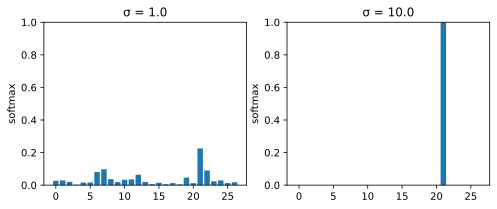

In [10]:
logits = torch.randn(size=(1, 27))

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].bar(range(27), F.softmax(logits)[0]);
ax[1].bar(range(27), F.softmax(logits * 10)[0]);

ax[0].set_ylabel("softmax")
ax[0].set_ylim(0, 1)
ax[0].set_title("σ = 1.0")

ax[1].set_ylabel("softmax")
ax[1].set_ylim(0, 1)
ax[1].set_title("σ = 10.0");

Note that the model in the right plot is more likely to incur high penalty from the cross-entropy loss due to potentially being more confidently wrong. This can be the source of the high loss value at initialization.
Hence, we want to make sure to control the spread of values of the logits from its mean of zero. 

### Fixing logits weights

As shown above, a low spread of values for the weights of the logits layer fixes the high initial loss. You may be wondering if zeroing out the weights work. But this doesn't work due to symmetry in the structure of the MLP network. Such a model will learn the same number for the weights of the logits layer. Best is a combination of low values, along with some entropy for symmetry breaking.

In [11]:
model = MLP(
    embedding_size=10, width=200, block_size=3, 
    scale_logits=lambda fan_in, fan_out: 0.01
)

hist = trainer.run(model, 200000, lr=0.1, verbose=True)
update_results(trainer, message='fix: logits')

[000001/200000]      loss=3.4008      loss_val=3.2788
[006251/200000]      loss=2.1725      loss_val=2.3613
[012501/200000]      loss=2.1751      loss_val=2.3440
[018751/200000]      loss=2.2406      loss_val=2.2985
[025001/200000]      loss=2.3390      loss_val=2.2949
[031251/200000]      loss=2.1109      loss_val=2.2879
[037501/200000]      loss=2.2022      loss_val=2.2995
[043751/200000]      loss=1.8708      loss_val=2.2836
[050001/200000]      loss=2.1965      loss_val=2.2711
[056251/200000]      loss=2.2204      loss_val=2.2599
[062501/200000]      loss=2.0435      loss_val=2.2691
[068751/200000]      loss=2.3817      loss_val=2.2462
[075001/200000]      loss=1.9741      loss_val=2.2595
[081251/200000]      loss=2.3346      loss_val=2.2586
Decreasing learning rate to 1.00e-02
[087501/200000]      loss=2.2291      loss_val=2.2723
[093751/200000]      loss=2.2206      loss_val=2.1478
[100001/200000]      loss=1.9294      loss_val=2.1481
[106251/200000]      loss=1.9958      loss_va

The network has the architecture as before but now starts with a good loss (around 3.2). In this case, instead of wasting training steps squashing the logits that are large during initialization, the model gets to focus on the hard gains during training. So the loss does not look too much like a hockey stick.

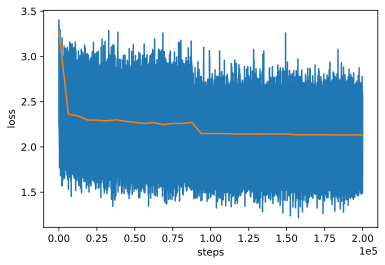

In [12]:
plot_training_results(hist)

### Flat activation regions

The next thing we want to check is the activations in the hidden layer. Reinitializing the network (undoing training):

In [13]:
model = MLP(
    embedding_size=10, width=200, block_size=3, 
    scale_logits=lambda fan_in, fan_out: 0.01
)

Passing one random mini batch:

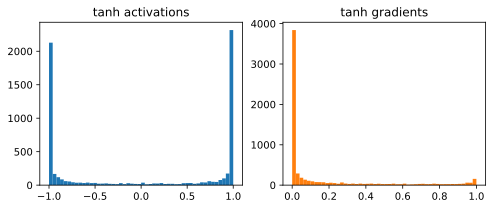

In [14]:
B = torch.randint(0, x_train.shape[0], (32,)) 
model(x_train[B])
h_act = model.out['h_act']

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].hist(h_act.reshape(-1).tolist(), bins=50, label='activations');
ax[1].hist((1 - h_act.reshape(-1)**2).tolist(), bins=50, color="C1", label='grads')
ax[0].set_title('tanh activations')
ax[1].set_title('tanh gradients');

This is due to large preactivations for tanh. If you are well-versed in the dark arts of backpropagation, you know that this is starting to look bad &mdash; the local gradients are zero for regions where tanh activation values saturate to $\pm 1.$ In fact, if we look at the histogram of local gradients of tanh, we can see that its mostly zero. 

This makes sense since in flat regions changing the input by a small amount does not change the tanh activations too much, and therefore has no impact on the loss. By extension, the corresponding weights and biases do not impact the loss, so that these parameters get zero gradient.

### Dead neurons

Another way to visualize this is as follows. Here white blocks indicate an activation where gradients are small. A dead neuron is a neuron whose gradient is mostly zero over the training examples. Here this is indicated by a white column. This can occur not only for tanh but for other nonlinearities which has flat activation regions such as sigmoid or ReLU. Dead neurons can sometimes happen at initialization:

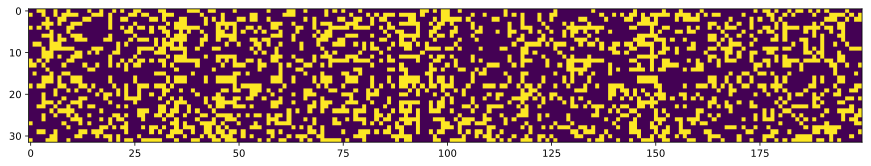

In [15]:
TANH_ACT_THRESHOLD = 0.97

plt.figure(figsize=(15, 3))
plt.imshow(h_act.abs() > TANH_ACT_THRESHOLD, cmap='viridis_r'); # yellow = alive, dark = saturated

This can also happen during training as shown here. For instance, a high learning rate results in neurons getting knocked off the data manifold. This means that from then on, no example activates this neuron, and this neuron remains dead forever (flowing gradients are too small to change the weights). Sort of like a permanent brain damage in the network. Showing this by training the network with a large learning rate:

In [16]:
model = MLP(
    embedding_size=10, width=200, block_size=3, 
    scale_logits=lambda fan_in, fan_out: 0.01
)


# (!) large learning rate
trainer.run(model, num_steps=200000, lr=1.0, verbose=False);

Dark columns are saturated activations of one neuron for the entire batch:

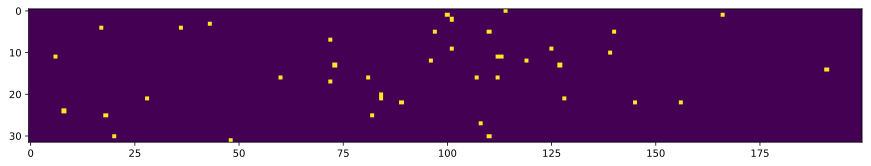

In [17]:
B = torch.randint(0, x_train.shape[0], (32,)) 
model(x_train[B])
h_act = model.out['h_act']

plt.figure(figsize=(15, 3))
plt.imshow(h_act.abs() > TANH_ACT_THRESHOLD, cmap='viridis_r'); # yellow = alive, dark = saturated

### Fixing the saturated tanh

An easy way to fix saturated tanh is to simply reduce the range of values in the preactivation of the hidden layers.

In [18]:
model = MLP(
    embedding_size=10, width=200, block_size=3, 
    scale_hidden=lambda fan_in, fan_out: 0.2,
    scale_logits=lambda fan_in, fan_out: 0.01
)

Passing one mini-batch:

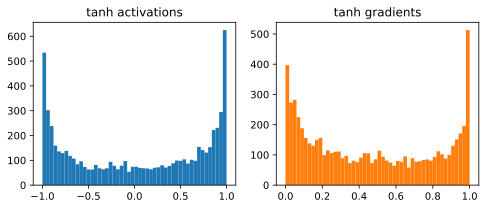

In [19]:
B = torch.randint(0, x_train.shape[0], (32,)) 
model(x_train[B])
h_act = model.out['h_act']

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].hist(h_act.reshape(-1).tolist(), bins=50);
ax[1].hist((1 - h_act.reshape(-1)**2).tolist(), bins=50, color="C1")
ax[0].set_title('tanh activations')
ax[1].set_title('tanh gradients');

By lowering preactivation values, we get tanh activation values that are not saturated. Consequently, we have more nonzero gradients. Full training with better initialization:

In [20]:
trainer = Engine(
    x_train, y_train, 
    x_valid, y_valid, 
    batch_size=32
)

trainer.run(model, num_steps=200000, verbose=False, lr_find=True, lre_min=-4)
update_results(trainer, message='fix: tanh')

Setting learning rate to 5.58e-02
train loss: 2.0469748973846436
valid loss: 2.1156516075134277


### Xavier initialization

Note that the scale factors for the weights can be difficult to choose optimally. Indeed, this is just to motivate the more precise initialization scheme that we will develop here. Observe that the output $\boldsymbol{\mathsf{y}} = \boldsymbol{\mathsf{x}}^\top \boldsymbol{\mathsf{w}}$ for $\boldsymbol{\mathsf{x}}, \boldsymbol{\mathsf{w}} \sim \mathcal{G}_{\mu=0, \sigma^2=1}$ starts to spread out. This makes sense since we are adding multiple terms equal to the width of the layer.

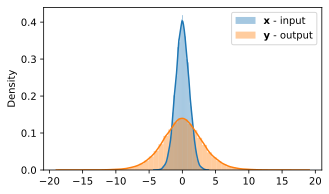

In [21]:
import seaborn as sns

x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w

plt.figure(figsize=(5, 3))
sns.distplot(x.reshape(-1), color="C0", label='$\mathbf{x}$ - input');
sns.distplot(y.reshape(-1), color="C1", label='$\mathbf{y}$ - output');
plt.legend();

```{margin}
**Xavier init**
```

Ideally, we want the standard deviation of $\boldsymbol{\mathsf{y}}$ to be also $1$ to maintain stable activation flow. Otherwise, activations will recursively grow at each layer. This becomes increasingly problematic for deep networks. One straightforward fix is to initialize the weights $\boldsymbol{\mathsf{w}}$ with a distribution having $\sigma^2=\frac{1}{n_{\text{in}}}$ where $n_{\text{in}}$ is the length of $\boldsymbol{\mathsf{x}}.$ Note that setting the standard deviation turns out to be equivalent to just scaling the random variable with $\frac{1}{\sqrt{n_{\text{in}}}}$ (e.g. by linearity of expectation):

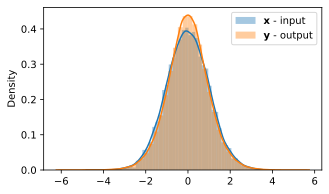

In [22]:
n = 10
x = torch.randn(1000, n)
w = torch.randn(n, 200) / n**0.5
y = x @ w

plt.figure(figsize=(5, 3))
sns.distplot(x.reshape(-1), color="C0", label='$\mathbf{x}$ - input');
sns.distplot(y.reshape(-1), color="C1", label='$\mathbf{y}$ - output');
plt.legend();

```{margin}
**Xavier with gain**
```

This looks nice! Observe that nonlinear activations **squashes** its input, which compounds as we stack layers in deep networks. To compensate for this, a factor called  [gain](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain) is introduced in the standard deviation, e.g. $\sigma = \left(\frac{5}{3} \right)\frac{1}{\sqrt{n}}$ for tanh. Applying this to our network: 

In [23]:
model = MLP(
    embedding_size=10, width=200, block_size=3, 
    scale_hidden=lambda fan_in, fan_out: (5 / 3) / (fan_in ** 0.5),
    scale_logits=lambda fan_in, fan_out: 0.01
)

trainer.run(model, 200000, verbose=False, lr_find=True, lre_min=-4)
update_results(trainer, message="fix: xavier+gain")

Setting learning rate to 1.27e-01
train loss: 2.037741184234619
valid loss: 2.11130690574646


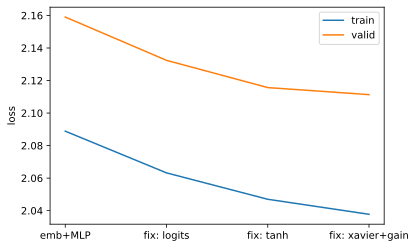

In [24]:
plt.plot(pd.DataFrame(results).loc['train'], label='train')
plt.plot(pd.DataFrame(results).loc['valid'], label='valid')
plt.ylabel('loss')
plt.legend();

The last update here is probably just random noise. But what is important is that we now have a semi-principled approach to initializing the weights instead of using arbitrary factors. This will serve as sort of a guide to scale us to much bigger and deeper networks. 

**Remarks.** Gradients also need to have stable flow across the layers. It turns out that for a linear layer $\sigma^2=\frac{1}{n_{\text{out}}}$ works where $m$ is the number of output neurons. This makes sense since gradients flow in the reverse direction. To include the constraints in both directions, we can use the harmonic mean $\sigma^2=\frac{2}{n_{\text{in}} + n_{\text{out}}}.$ 

## Batch Normalization

We went quickly through the weight initialization schemes. This was intentional. Before practitioners needed to be really careful with activation and gradient ranges and histograms, as well as the precise setting of gains and the nonlinearities used. Everything was finicky and fragile, and very properly arranged for the neural net to train. This is especially true for very deep networks. Modern innovations that made everything more stable, so that there is no need to initialize exactly right:

- Residual connections {cite}`resnet`
- Normalization layers (e.g. BatchNorm {cite}`batchnorm`, LayerNorm {cite}`layernorm`, GroupNorm {cite}`groupnorm`)
- Better optimizers (e.g. [RMSProp](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf), Adam {cite}`adam` a.k.a. neural net cheat code)

Batch Normalization was extremely impactful when it first came out in 2015. It made it possible to train very deep nets quite reliably. Fundamentally, the reason is that it is very effective in controlling the statistics of the activations of neural networks. The idea of the BatchNorm layer is that if we want preactivations to be roughly Gaussian, then we can just normalize them along the mini-batch. Turns out this operation is differentiable! 🤯

### BatchNorm parameters

But using only normalization will not give you good results as this severely limits the expressivity of the neurons. We want the distributions to be unit Gaussian only at initialization. As the network learns, we want backpropagation to move the distributions around so that the neurons learn more varied activation patterns. 

Hence, the BatchNorm layer implements two trainable parameters that control the scale and shift of each output neuron. These are learned along with two nontrainable parameters, the moving mean and moving variance, that are used in place of the batch statistics during inference.

```{figure} ../../img/batchnorm-algo1.png
---
width: 400px
name: batchnorm-algo1
---

```

### Modularity

For deeper networks with more complex operations, e.g. residual connections or convolutions, it will become very difficult to tune the scales of the weight matrices such that all
activations are roughly Gaussian. The math very quickly becomes intractable. It is much much easier in practice to just sprinkle BatchNorm layer. This technique just works generically for any new layer that we introduce in the future. Herein lies the strength of Batch Normalization that is shared by other more recent normalization layers in deep learning. 

```{figure} ../../img/resnet-nicepic.png
---
width: 400px
name: resnet-nicepic
---
BatchNorm layers sprinkled between DenseNet blocks {cite}`densenet`.
```

### Implementation

In this section, we will discuss implementation details. Observe that we will append BatchNorm after linear layers. This allows the parameters of BatchNorm to be folded into the linear layers, making it more efficient during inference. Note also that the bias on linear layers can now be removed (i.e. set to `bias=False`) since normalization will subtract these out anyway. This is compensated by the bias of the BatchNorm layer.

In [25]:
class BatchNorm1d:
    def __init__(self, width, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum

        # parameters (trained with backprop)
        self.gamma = torch.ones (width)
        self.beta  = torch.zeros(width)
        
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(1, width)
        self.running_var  = torch.ones (1, width)

    def __call__(self, x, training=False):
        if training:
            x_mean = x.mean(0, keepdim=True)
            x_var  = x.var (0, keepdim=True)
        
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var  = (1 - self.momentum) * self.running_var  + self.momentum * x_var
        else:
            x_mean = self.running_mean
            x_var  = self.running_var

        xhat = (x - x_mean) / torch.sqrt(x_var + self.eps)
        self.out = self.gamma * xhat + self.beta
        return self.out

    def parameters(self):
        return [("scale", self.gamma), ("bias", self.beta)]

### BatchNorm Bad

The benefits of Batch Normalization come at a huge cost: our mini batches are now coupled mathematically during forward and backward pass. Although this has a nice regularization effect by adding some noise on the training example as a result of the other examples in the batch, this turns out to be really bug prone. 

For example, sampling noise increase with lower batch sizes, resulting in worse performance for BatchNorm (Table 2 in {cite}`groupnorm`). See also [this issue](https://github.com/pytorch/pytorch/issues/1410). In fact, our implementation differs from PyTorch and the original paper in that it uses the unbiased variance for both train and running variance. In general, we want to avoid Batch Normalization as much as possible. There are more recent normalization techniques that have the same benefits, but do not have this coupling issue {cite}`groupnorm` {cite}`layernorm`.

## Training a deeper network

Here we will train a deep network for 1000 gradient updates. To make a deeper network, we simply introduce a `layers` argument that will contain the layers of the MLP that processes embeddings to make this subnetwork deeper.

In [26]:
class Embedding:
    def __init__(self, embedding_size: int, vocab_size=27, generator=None):
        self.embedding_size = embedding_size
        self.vocab_size = vocab_size
        self.g = get_generator(generator)
        self.C = torch.randn(vocab_size, embedding_size, generator=self.g)

    def __call__(self, x, training=False):
        block_size = x.shape[1]
        self.out = self.C[x].view(-1, block_size * self.embedding_size)
        return self.out

    def parameters(self):
        return [("weights", self.C)]


class Linear:
    def __init__(self, 
            fan_in: int, fan_out: int, 
            gain=1.0,
            bias=True, 
            generator=None
        ):

        self.g = get_generator(generator)
        self.W = torch.randn((fan_in, fan_out), generator=self.g) * gain / fan_in ** 0.5
        self.b = torch.zeros(fan_out) if bias else None

    def __call__(self, x, training=False):
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out

    def parameters(self):
        return [("weights", self.W)] + ([("bias", self.b)] if self.b is not None else [])


class Tanh:
    def __call__(self, x, training=False):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class DeepMLP:
    def __init__(self, embedding_size, block_size, layers, vocab_size=27, generator=None):

        self.embedding_size = embedding_size
        self.block_size = block_size
        self.vocab_size = vocab_size
        
        self.g = get_generator(generator)
        self.emb = Embedding(embedding_size, vocab_size, self.g)
        self.layers = [(self.emb.__class__.__name__+".0", self.emb)] + \
            [(l.__class__.__name__+f".{i+1}", l) for i, l in enumerate(layers)]
        
        for _, param in self.parameters():
            param.requires_grad = True

    def parameters(self):
        params = []
        for layer_name, layer in self.layers:
            for param_name, param in layer.parameters():
                params.append((f'{layer_name}.{param_name}', param))
        return params

    def __call__(self, x, training=False):
        for _, layer in self.layers:
            x = layer(x, training)
        self.out = x
        return self.out

    def zero_grad(self):
        for _, param in self.parameters():
           param.grad = None

We want to monitor training, so we define a new training function. This retains the gradient of output tensors which are non-leaf. PyTorch, by default, discards these gradients.

In [27]:
def monitor_train_model(
        model,
        x_train, y_train,
        batch_size, num_steps, lr=0.1,
        generator=None,
    ):

    g = get_generator(generator)
    losses_trn = {}
    param_update_ratio = {param_name: [] for param_name, _ in model.parameters()}
    
    print(f"Setting learning rate to {lr:.2e}")
    
    for k in range(num_steps):
        B = torch.randint(
            0, x_train.shape[0], 
            (batch_size,), 
            generator=g
        )
        logits = model(x_train[B], training=True)
        loss = F.cross_entropy(logits, target=y_train[B])

        model.zero_grad()
        for _, layer in model.layers:
            layer.out.retain_grad()

        loss.backward()
        for _, p in model.parameters():
            p.data -= lr * p.grad
        
        losses_trn[k] = loss.item()

        with torch.no_grad():
            for n, p in model.parameters():
                update_ratio = ((lr * p.grad).std() / p.data.std()).log10().item()
                param_update_ratio[n].append(update_ratio)

    return {"loss_trn": losses_trn, "loss_dev": [], "param_update_ratio": param_update_ratio}

Again, here we set the linear layers to have no bias. This is because there will be zero gradients flowing into it anyway since they don't affect the output of the model. Having biases only wastes compute resources. Note also that it can also help to use BatchNorm on the logits:

In [28]:
block_size      = 3
vocab_size      = 27
width           = 100
embedding_size  = 10

LOW_GAIN  = 0.4
HIGH_GAIN = 3.0
TANH_GAIN = 5/3


def create_nobn_model(layer_gain):
    layers = [
        Linear(embedding_size * block_size, width, gain=layer_gain), Tanh(),
        Linear(width, width, gain=layer_gain), Tanh(),
        Linear(width, width, gain=layer_gain), Tanh(),
        Linear(width, width, gain=layer_gain), Tanh(),
        Linear(width, width, gain=layer_gain), Tanh(),
        Linear(width, vocab_size, gain=0.1) # logits: make less confident
    ]
    model = DeepMLP(embedding_size, block_size, layers, vocab_size)
    return model


def create_bn_model(layer_gain):
    layers = [
        Linear(embedding_size * block_size, width, gain=layer_gain), BatchNorm1d(width), Tanh(),
        Linear(width, width, gain=layer_gain), BatchNorm1d(width), Tanh(),
        Linear(width, width, gain=layer_gain), BatchNorm1d(width), Tanh(),
        Linear(width, width, gain=layer_gain), BatchNorm1d(width), Tanh(),
        Linear(width, width, gain=layer_gain), BatchNorm1d(width), Tanh(),
        Linear(width, vocab_size, gain=layer_gain), BatchNorm1d(vocab_size)
    ]

    # logits: make less confident
    layers[-1].gamma *= 0.1

    model = DeepMLP(embedding_size, block_size, layers, vocab_size)
    return model


def create_experiment(
        batch_norm: bool, layer_gain: float, 
        batch_size=32, num_steps=1000, lr=0.1, generator=None
    ):
    """Create experiment artifacts for analysis below."""
    model = create_bn_model(layer_gain) if batch_norm else create_nobn_model(layer_gain)
    hist = monitor_train_model(model, x_train, y_train, batch_size, num_steps, lr, generator)
    return model, hist

Our goal is to show that networks without BatchNorm depend on a precise setting of the gains for its weight initialization. Our networks will use the recommended $\frac{5}{3}$ gain for Tanh, and a gain that is lower and higher than this. We will then add BatchNorm layers on the low gain and high gain setting to see whether Batch Normalization improves network performance. Collecting the models here for experimentation:

In [29]:
# Feel free to add other model configs here
experiments = []
for bn, gain in [(False, HIGH_GAIN), (True, HIGH_GAIN), (False, TANH_GAIN), (True, TANH_GAIN), (False, LOW_GAIN), (True, LOW_GAIN)]:
    model, hist = create_experiment(batch_norm=bn, layer_gain=gain)
    experiments.append({"model": model, "hist": hist, "label": f"BN={bn}, gain={gain:.3f}"})

Setting learning rate to 1.00e-01
Setting learning rate to 1.00e-01
Setting learning rate to 1.00e-01
Setting learning rate to 1.00e-01
Setting learning rate to 1.00e-01
Setting learning rate to 1.00e-01


Plotting the loss curves:

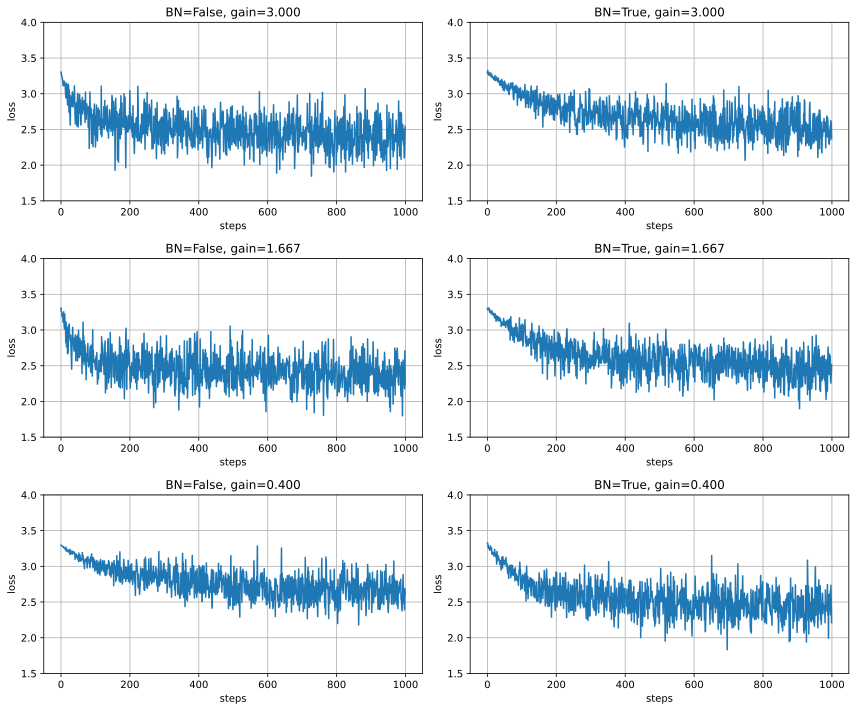

In [30]:
rows = math.ceil(len(experiments) / 2)
fig, ax = plt.subplots(rows, 2, figsize=(12, 10))

for i, experiment in enumerate(experiments):
    steps = list(experiment['hist']['loss_trn'].keys())
    train_loss_curve = list(experiment['hist']['loss_trn'].values())    
    ax[divmod(i, 2)].plot(steps, train_loss_curve)
    ax[divmod(i, 2)].set_xlabel("steps")
    ax[divmod(i, 2)].set_ylabel("loss")
    ax[divmod(i, 2)].set_title(experiment["label"])
    ax[divmod(i, 2)].set_ylim(1.5, 4)
    ax[divmod(i, 2)].grid(True)

fig.tight_layout()

### Activation distribution

We look at distribution of activation values for each layer.

BN=False, gain=3.000
(Tanh.2 ):  μ = -0.08  |  σ = 0.85  |  saturation = 43.97%
(Tanh.4 ):  μ = +0.03  |  σ = 0.86  |  saturation = 44.00%
(Tanh.6 ):  μ = +0.03  |  σ = 0.86  |  saturation = 45.66%
(Tanh.8 ):  μ = -0.04  |  σ = 0.86  |  saturation = 44.62%
(Tanh.10):  μ = +0.01  |  σ = 0.86  |  saturation = 43.94%


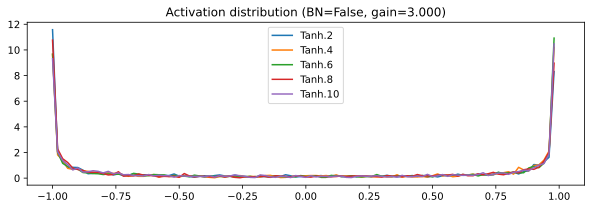

BN=True, gain=3.000
(Tanh.3 ):  μ = +0.01  |  σ = 0.63  |  saturation = 3.22%
(Tanh.6 ):  μ = +0.01  |  σ = 0.64  |  saturation = 2.59%
(Tanh.9 ):  μ = -0.00  |  σ = 0.64  |  saturation = 2.47%
(Tanh.12):  μ = +0.01  |  σ = 0.64  |  saturation = 2.59%
(Tanh.15):  μ = +0.00  |  σ = 0.65  |  saturation = 2.00%


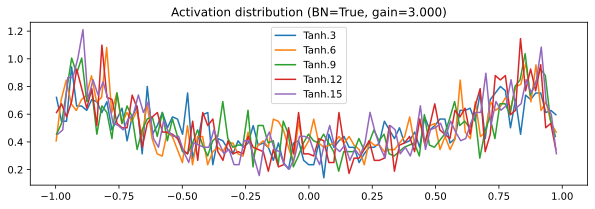

BN=False, gain=1.667
(Tanh.2 ):  μ = -0.04  |  σ = 0.74  |  saturation = 18.44%
(Tanh.4 ):  μ = -0.02  |  σ = 0.73  |  saturation = 13.34%
(Tanh.6 ):  μ = -0.01  |  σ = 0.73  |  saturation = 9.88%
(Tanh.8 ):  μ = -0.01  |  σ = 0.74  |  saturation = 12.09%
(Tanh.10):  μ = +0.02  |  σ = 0.72  |  saturation = 9.78%


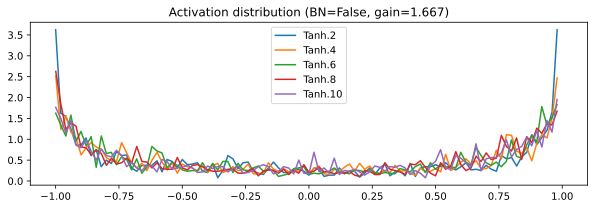

BN=True, gain=1.667
(Tanh.3 ):  μ = +0.00  |  σ = 0.62  |  saturation = 4.06%
(Tanh.6 ):  μ = +0.01  |  σ = 0.63  |  saturation = 3.09%
(Tanh.9 ):  μ = -0.01  |  σ = 0.64  |  saturation = 2.66%
(Tanh.12):  μ = -0.00  |  σ = 0.65  |  saturation = 1.97%
(Tanh.15):  μ = +0.00  |  σ = 0.65  |  saturation = 1.81%


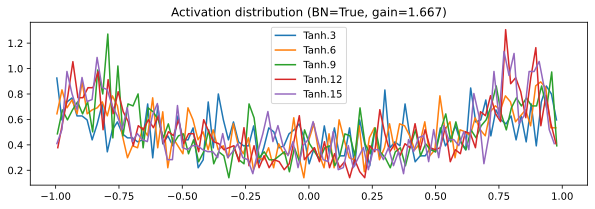

BN=False, gain=0.400
(Tanh.2 ):  μ = -0.01  |  σ = 0.37  |  saturation = 0.00%
(Tanh.4 ):  μ = +0.01  |  σ = 0.22  |  saturation = 0.00%
(Tanh.6 ):  μ = -0.00  |  σ = 0.19  |  saturation = 0.00%
(Tanh.8 ):  μ = -0.01  |  σ = 0.20  |  saturation = 0.00%
(Tanh.10):  μ = +0.04  |  σ = 0.26  |  saturation = 0.00%


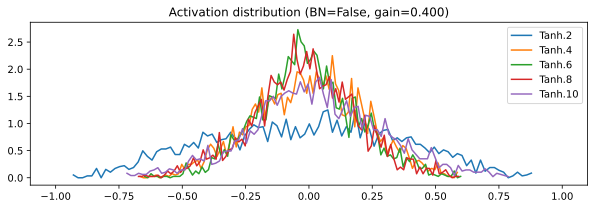

BN=True, gain=0.400
(Tanh.3 ):  μ = +0.00  |  σ = 0.63  |  saturation = 2.72%
(Tanh.6 ):  μ = +0.00  |  σ = 0.65  |  saturation = 2.03%
(Tanh.9 ):  μ = +0.00  |  σ = 0.65  |  saturation = 1.66%
(Tanh.12):  μ = +0.00  |  σ = 0.65  |  saturation = 1.59%
(Tanh.15):  μ = -0.00  |  σ = 0.66  |  saturation = 1.03%


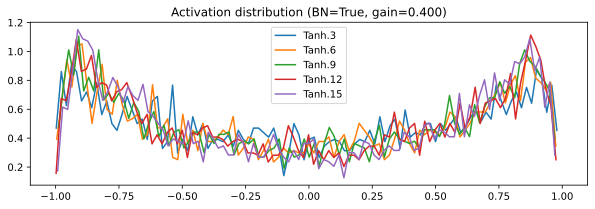

In [31]:
def activation_histograms(model, layer_type=Tanh, label=""):
    plt.figure(figsize=(10, 3))
    print(label)
    for layer_name, layer in model.layers[:-1]: # Exclude logits/output layer.
        if isinstance(layer, layer_type):
            t = layer.out
            print(f'({layer_name:<7}):  μ = {t.mean():+.2f}  |  σ = {t.std():.2f}  |  saturation = {((t.abs() > TANH_ACT_THRESHOLD).float().mean() * 100):.2f}%')            
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach(), label=layer_name) # Skip rightmost histbar endpoint.
            plt.xlim(-1.1, 1.1)

    plt.legend()
    plt.title(f'Activation distribution ({label})')
    plt.show();


for i, experiment in enumerate(experiments):
    activation_histograms(experiment['model'], layer_type=Tanh, label=experiment['label'])

Observe that increasing gain results in increasing saturation. Indeed, recall that we introduced gain to balance out the squashing effect of activations. On the other hand, with low gain, activation values have decreasing range around zero. Choosing a good value for the gain, balances these effects. Having BatchNorm layers in both cases result in controlled saturation (decreasing from 3%). But also with a good range (`σ = 0.65`) that is stable with depth for the same low gain.

### Activation gradients

This is same plot as above but for gradients of activation neurons. We want to make sure that gradients neither vanishing nor exploding.

BN=False, gain=3.000
(Tanh.2 ):  μ = -0.0000  |  σ = 0.0063
(Tanh.4 ):  μ = -0.0002  |  σ = 0.0054
(Tanh.6 ):  μ = +0.0001  |  σ = 0.0042
(Tanh.8 ):  μ = +0.0000  |  σ = 0.0031
(Tanh.10):  μ = -0.0001  |  σ = 0.0023


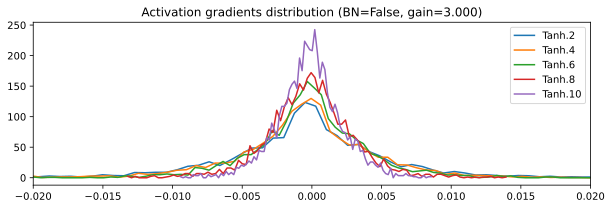

BN=True, gain=3.000
(Tanh.3 ):  μ = +0.0000  |  σ = 0.0035
(Tanh.6 ):  μ = -0.0000  |  σ = 0.0032
(Tanh.9 ):  μ = -0.0000  |  σ = 0.0029
(Tanh.12):  μ = +0.0000  |  σ = 0.0026
(Tanh.15):  μ = -0.0000  |  σ = 0.0025


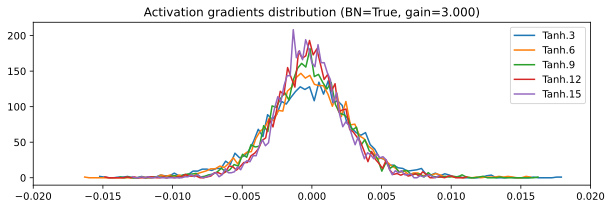

BN=False, gain=1.667
(Tanh.2 ):  μ = -0.0000  |  σ = 0.0029
(Tanh.4 ):  μ = -0.0000  |  σ = 0.0028
(Tanh.6 ):  μ = -0.0000  |  σ = 0.0026
(Tanh.8 ):  μ = +0.0001  |  σ = 0.0026
(Tanh.10):  μ = -0.0000  |  σ = 0.0023


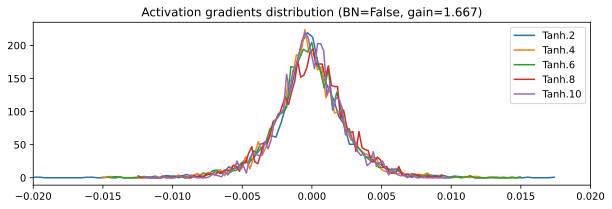

BN=True, gain=1.667
(Tanh.3 ):  μ = +0.0000  |  σ = 0.0026
(Tanh.6 ):  μ = -0.0000  |  σ = 0.0023
(Tanh.9 ):  μ = -0.0000  |  σ = 0.0022
(Tanh.12):  μ = +0.0000  |  σ = 0.0023
(Tanh.15):  μ = +0.0000  |  σ = 0.0024


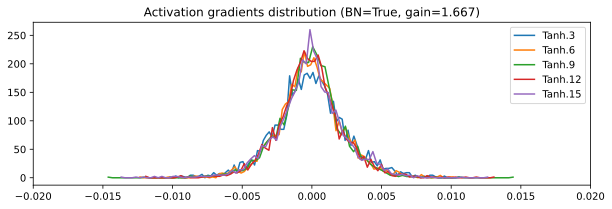

BN=False, gain=0.400
(Tanh.2 ):  μ = +0.0000  |  σ = 0.0012
(Tanh.4 ):  μ = -0.0000  |  σ = 0.0013
(Tanh.6 ):  μ = -0.0000  |  σ = 0.0012
(Tanh.8 ):  μ = -0.0000  |  σ = 0.0012
(Tanh.10):  μ = +0.0000  |  σ = 0.0012


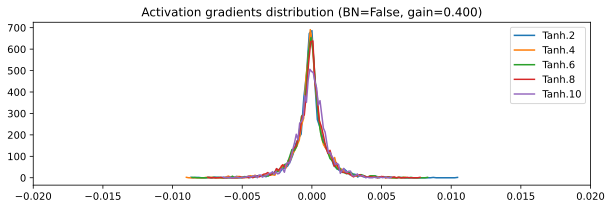

BN=True, gain=0.400
(Tanh.3 ):  μ = +0.0000  |  σ = 0.0014
(Tanh.6 ):  μ = -0.0000  |  σ = 0.0012
(Tanh.9 ):  μ = +0.0000  |  σ = 0.0011
(Tanh.12):  μ = +0.0000  |  σ = 0.0011
(Tanh.15):  μ = -0.0000  |  σ = 0.0012


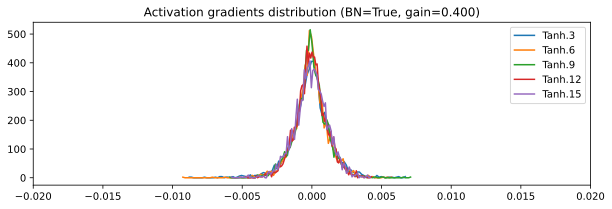

In [32]:
def activation_gradient_histograms(model, layer_type=Tanh, label=""):
    plt.figure(figsize=(10, 3))
    print(label)
    for layer_name, layer in model.layers[:-1]: # Exclude logits/output layer.
        if isinstance(layer, layer_type):
            t = layer.out.grad
            print(f'({layer_name:<7}):  μ = {t.mean():+.4f}  |  σ = {t.std():.4f}')            
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach(), label=layer_name) # Skip rightmost edge.
            plt.xlim(-0.02, 0.02)

    plt.legend()
    plt.title(f'Activation gradients distribution ({label})')
    plt.show()


for i, experiment in enumerate(experiments):
    activation_gradient_histograms(experiment['model'], label=experiment['label'])

Choosing a good gain results in a more stable gradient distribution. Using too high or too low gains result in gradient distributions that are not symmetric as we go deeper from the loss to the input layer. Observe that by adding BatchNorm layers, the distributions generally become more symmetric and have more stable ranges.

### Weight gradients

Plotting gradient distribution of weight matrices:

BN=False, gain=3.000
(Embedding.0.weights):  μ = -0.0008  |  σ = 0.0263  |  grad/data ≈ 0.029
(Linear.1.weights   ):  μ = +0.0001  |  σ = 0.0142  |  grad/data ≈ 0.026
(Linear.3.weights   ):  μ = +0.0002  |  σ = 0.0105  |  grad/data ≈ 0.035
(Linear.5.weights   ):  μ = -0.0000  |  σ = 0.0085  |  grad/data ≈ 0.028
(Linear.7.weights   ):  μ = -0.0000  |  σ = 0.0066  |  grad/data ≈ 0.022
(Linear.9.weights   ):  μ = +0.0001  |  σ = 0.0047  |  grad/data ≈ 0.016
(Linear.11.weights  ):  μ = +0.0000  |  σ = 0.0274  |  grad/data ≈ 0.382


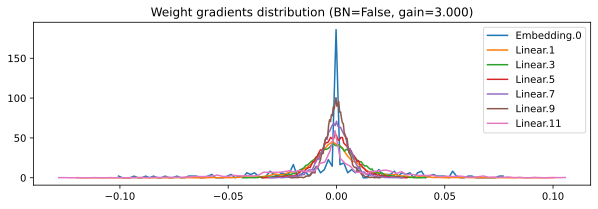

BN=True, gain=3.000
(Embedding.0.weights):  μ = +0.0000  |  σ = 0.0066  |  grad/data ≈ 0.006
(Linear.1.weights   ):  μ = +0.0001  |  σ = 0.0043  |  grad/data ≈ 0.008
(Linear.4.weights   ):  μ = +0.0000  |  σ = 0.0036  |  grad/data ≈ 0.012
(Linear.7.weights   ):  μ = +0.0001  |  σ = 0.0034  |  grad/data ≈ 0.011
(Linear.10.weights  ):  μ = +0.0000  |  σ = 0.0030  |  grad/data ≈ 0.010
(Linear.13.weights  ):  μ = +0.0000  |  σ = 0.0027  |  grad/data ≈ 0.009
(Linear.16.weights  ):  μ = -0.0001  |  σ = 0.0049  |  grad/data ≈ 0.016


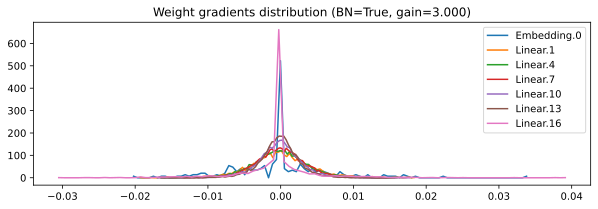

BN=False, gain=1.667
(Embedding.0.weights):  μ = +0.0001  |  σ = 0.0106  |  grad/data ≈ 0.010
(Linear.1.weights   ):  μ = +0.0000  |  σ = 0.0088  |  grad/data ≈ 0.029
(Linear.3.weights   ):  μ = -0.0001  |  σ = 0.0069  |  grad/data ≈ 0.041
(Linear.5.weights   ):  μ = -0.0000  |  σ = 0.0063  |  grad/data ≈ 0.038
(Linear.7.weights   ):  μ = +0.0000  |  σ = 0.0054  |  grad/data ≈ 0.032
(Linear.9.weights   ):  μ = +0.0001  |  σ = 0.0052  |  grad/data ≈ 0.031
(Linear.11.weights  ):  μ = -0.0000  |  σ = 0.0202  |  grad/data ≈ 0.292


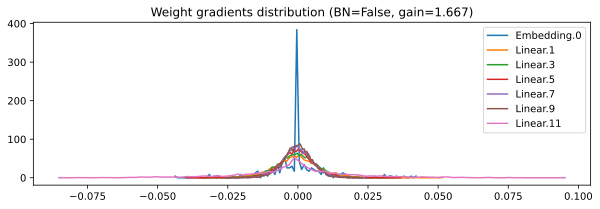

BN=True, gain=1.667
(Embedding.0.weights):  μ = +0.0000  |  σ = 0.0070  |  grad/data ≈ 0.007
(Linear.1.weights   ):  μ = +0.0002  |  σ = 0.0059  |  grad/data ≈ 0.019
(Linear.4.weights   ):  μ = +0.0001  |  σ = 0.0051  |  grad/data ≈ 0.030
(Linear.7.weights   ):  μ = -0.0001  |  σ = 0.0047  |  grad/data ≈ 0.028
(Linear.10.weights  ):  μ = -0.0000  |  σ = 0.0047  |  grad/data ≈ 0.028
(Linear.13.weights  ):  μ = +0.0000  |  σ = 0.0051  |  grad/data ≈ 0.030
(Linear.16.weights  ):  μ = -0.0000  |  σ = 0.0101  |  grad/data ≈ 0.060


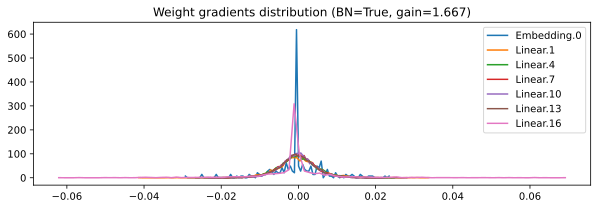

BN=False, gain=0.400
(Embedding.0.weights):  μ = -0.0001  |  σ = 0.0042  |  grad/data ≈ 0.004
(Linear.1.weights   ):  μ = +0.0001  |  σ = 0.0067  |  grad/data ≈ 0.088
(Linear.3.weights   ):  μ = -0.0000  |  σ = 0.0029  |  grad/data ≈ 0.069
(Linear.5.weights   ):  μ = -0.0000  |  σ = 0.0012  |  grad/data ≈ 0.029
(Linear.7.weights   ):  μ = -0.0000  |  σ = 0.0009  |  grad/data ≈ 0.021
(Linear.9.weights   ):  μ = +0.0000  |  σ = 0.0010  |  grad/data ≈ 0.022
(Linear.11.weights  ):  μ = -0.0000  |  σ = 0.0079  |  grad/data ≈ 0.181


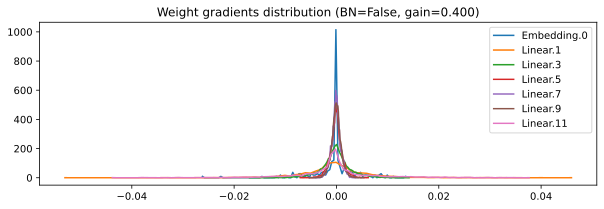

BN=True, gain=0.400
(Embedding.0.weights):  μ = +0.0000  |  σ = 0.0078  |  grad/data ≈ 0.008
(Linear.1.weights   ):  μ = +0.0005  |  σ = 0.0119  |  grad/data ≈ 0.139
(Linear.4.weights   ):  μ = -0.0001  |  σ = 0.0070  |  grad/data ≈ 0.149
(Linear.7.weights   ):  μ = -0.0001  |  σ = 0.0063  |  grad/data ≈ 0.142
(Linear.10.weights  ):  μ = +0.0001  |  σ = 0.0061  |  grad/data ≈ 0.139
(Linear.13.weights  ):  μ = -0.0000  |  σ = 0.0056  |  grad/data ≈ 0.128
(Linear.16.weights  ):  μ = -0.0000  |  σ = 0.0120  |  grad/data ≈ 0.214


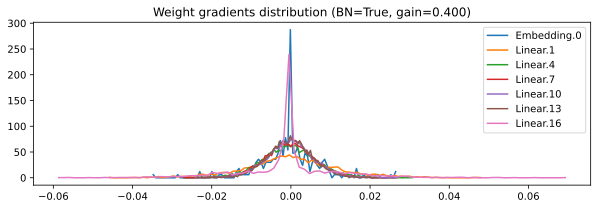

In [33]:
def weight_gradients_histograms(model, label=""):
    plt.figure(figsize=(10, 3))
    print(label)
    for param_name, param in model.parameters():
        if "weights" in param_name:
            print(f'({param_name:<19}):  μ = {param.grad.mean():+.4f}  |  σ = {param.grad.std():.4f}  |  grad/data ≈ {param.grad.std() / param.std():.3f}')            
            hy, hx = torch.histogram(param.grad, density=True)
            plt.plot(hx[:-1].detach(), hy.detach(), label=param_name[:-len(".weights")]) # Skip rightmost edge.
    
    plt.legend()
    plt.title(f'Weight gradients distribution ({label})')
    plt.show();


for i, experiment in enumerate(experiments):
    weight_gradients_histograms(experiment['model'], label=experiment['label'])

Observe that the logits layer trains many times faster than the other layers of the network. For networks initialized with high gain, adding BatchNorm layers fixes this resulting in fairly equal grad to data ratio across layers. Also note that distribution of weight gradients has better range and stability across layers with BatchNorm.

For networks initialized with low gain, the effect of BatchNorm in reducing the gradient to data ratio is significantly less. But what BatchNorm does instead is to increase the ratio of the other linear layers. Again, this results in more stable grad to data ratio across layers.

### Parameter update ratio

Note that the grad to data ratio in the above graphs is a snapshot for the final training step. Let us look at how this value evolves over the course of training. More precisely, we look at $\mathsf{y}$ such that ${\sigma(\lambda {\boldsymbol{\mathsf{w}}}_{g})} = {10}^{\mathsf{y}}\, {\sigma(\boldsymbol{\mathsf{w}})}$ where $\boldsymbol{\mathsf{w}}_{g}$ is the gradient of the loss with respect to the weights with value $\boldsymbol{\mathsf{w}}$. 

A low value of $\mathsf{y}$ means that convergence during training may be slow, while a high value may result in overshooting the minimum (or unlearning good weights). As a heuristic, the line `y= -3` is indicated corresponding to an update ratio of `0.001` for one mini-batch. This comes from the size of the dataset divided by the batch size: `182,516 / 32 ~ 6x10^3`. Hence, the line marks `1/6` of the dataset as the optimal number of steps to write off the current value of the weight.

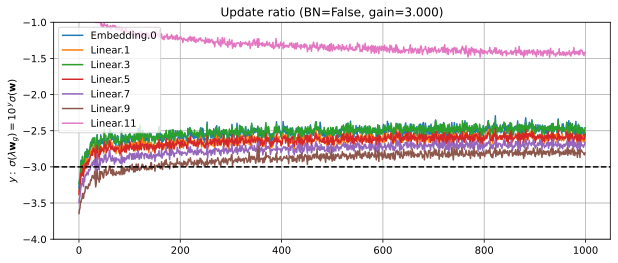

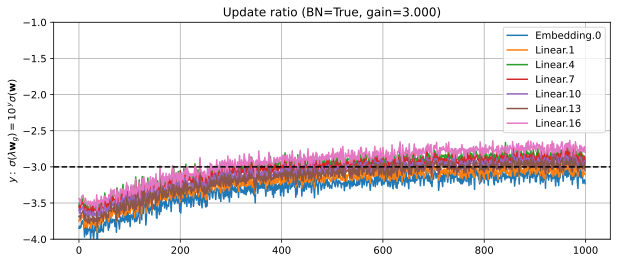

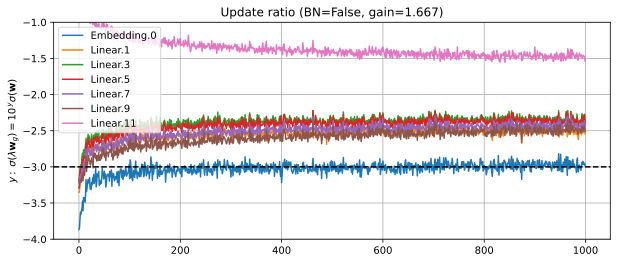

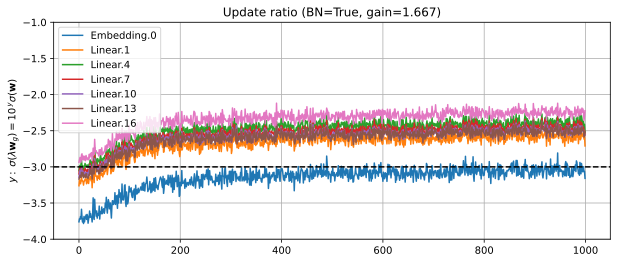

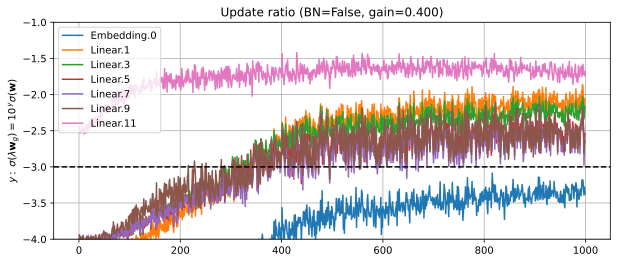

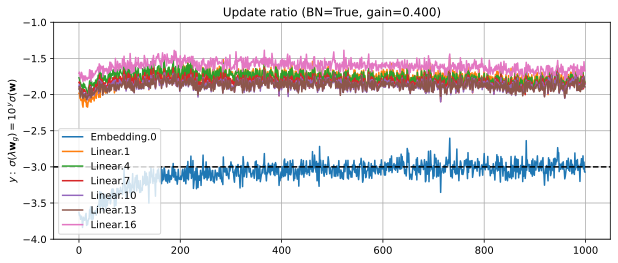

In [34]:
def plot_average_update_sizes(hist, label=""):
    plt.figure(figsize=(10, 4))
    for param_name, ud in hist['param_update_ratio'].items():
        if "weights" in param_name:
            plt.plot(ud, label=param_name[:-len(".weights")])
    
    plt.axhline(-3, color='k', linestyle='--')
    plt.ylim(-4, -1)
    plt.grid()
    plt.ylabel(r"$y:\; {\sigma(\lambda {\mathbf{w}}_{g})} = {10}^{\,y} {\sigma(\mathbf{w})}$")
    plt.legend()
    plt.title(f"Update ratio ({label})")
    plt.show()


for i, experiment in enumerate(experiments):
    plot_average_update_sizes(experiment['hist'], label=experiment['label'])

As we have seen in the previous test, the output layer updates slower compared to intermediate MLP layers. This is true for all choice of gain. With lower gains, the embedding layer separates further with a lower update ratio, but we get noiser curves and a slower convergence (i.e. takes more steps to flatten out). 
This is fixed for all gains by using BatchNorm layers (although still nicely has the highest update ratio). Also, the ordering of the update ratio for the layers also make sense with BatchNorm (e.g. input layer curve is closest to embedding layer curve). Finally, observe that the curves converge at a better rate, and the noise seems to be more uniform regardless of the choice of gain.

Regarding the curve for embedding layer, we want the embedding layer to have slower updates compared to the layers in the MLP network, as sudden updates to the embeddings can undo what the entire MLP has learned. Using BatchNorm with high gain, the embedding curve moves downward fixing the ordering. And with low gain, the embedding curve moves a bit higher, while the curves for the MLP layers likewise moves upward clustering with the curve for the output layer. Overall the network with BatchNorm layers and initialized with the recommended gain of $\frac{5}{3}$ seems to possess all of the desirable properties of the other networks that we discussed.

## Final remarks

In this notebook, we did not attempt to use BatchNorm to improve our language model. Using BatchNorm for our network
results in little improvement since the network is small and shallow. For example, we already know an optimal gain for the tanh layers, so that the BatchNorm layer is not doing much. 

If we increase the network depth, so that BatchNorm becomes relevant, performance improves:

Setting learning rate to 2.96e-02
[000001/300000]      loss=2.6191      loss_val=2.5484
[009376/300000]      loss=1.8152      loss_val=2.2198
[018751/300000]      loss=2.1992      loss_val=2.1777
[028126/300000]      loss=1.9088      loss_val=2.1576
[037501/300000]      loss=2.1195      loss_val=2.1554
[046876/300000]      loss=1.9641      loss_val=2.1458
[056251/300000]      loss=2.1714      loss_val=2.1373
[065626/300000]      loss=2.2696      loss_val=2.1332
[075001/300000]      loss=1.9615      loss_val=2.1338
[084376/300000]      loss=1.8614      loss_val=2.1274
[093751/300000]      loss=2.0042      loss_val=2.1276
[103126/300000]      loss=1.9853      loss_val=2.1258
[112501/300000]      loss=2.2406      loss_val=2.1186
[121876/300000]      loss=2.0486      loss_val=2.1199
[131251/300000]      loss=2.1629      loss_val=2.1161
[140626/300000]      loss=1.8222      loss_val=2.1178
[150001/300000]      loss=1.7388      loss_val=2.1201
Decreasing learning rate to 2.96e-03
[159376/300

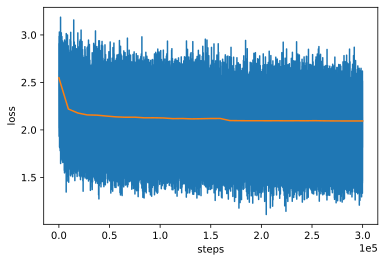

In [35]:
model_bn = create_bn_model(layer_gain=TANH_GAIN)

# Training: Note we use more steps since its a deeper model
hist_bn = trainer.run(model, 300000, lr_find=True, verbose=True)
plot_training_results(hist_bn)

train loss: 1.9576278924942017
valid loss: 2.0940937995910645


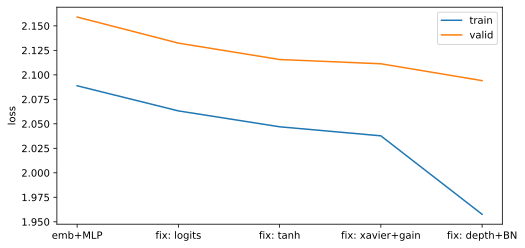

In [36]:
update_results(trainer, "fix: depth+BN")

plt.figure(figsize=(8, 4))
plt.plot(pd.DataFrame(results).loc['train'], label='train')
plt.plot(pd.DataFrame(results).loc['valid'], label='valid')
plt.ylabel('loss')
plt.legend();

But these results indicate that the network is starting to overfit. This tells us that our model is not bottlenecked by the optimization or by depth (of the MLP subnetwork). Most likely our results are limited by block size. We will continue in this direction in future notebooks.

## Appendix: Folding BatchNorm to linear layers

Observe that `γ(x @ W - u)/s + β = x @ (γ/s ⊙ W) + β - γu/s` where `u` is the running mean and `s` is the running standard deviation, and `⊙` broadcasts the row vector to W. This allows us to fold the BatchNorm layer into linear layers for significantly faster inference (i.e. one linear operation) at test time, especially for deep networks. 

In [37]:
model = create_bn_model(1.0)
model.layers

[('Embedding.0', <__main__.Embedding at 0x2944ea280>),
 ('Linear.1', <__main__.Linear at 0x2944c1d90>),
 ('BatchNorm1d.2', <__main__.BatchNorm1d at 0x2944d1e50>),
 ('Tanh.3', <__main__.Tanh at 0x2944fcdf0>),
 ('Linear.4', <__main__.Linear at 0x2944fc1f0>),
 ('BatchNorm1d.5', <__main__.BatchNorm1d at 0x2944dfdc0>),
 ('Tanh.6', <__main__.Tanh at 0x2944df820>),
 ('Linear.7', <__main__.Linear at 0x2944df790>),
 ('BatchNorm1d.8', <__main__.BatchNorm1d at 0x2944dff40>),
 ('Tanh.9', <__main__.Tanh at 0x2944df550>),
 ('Linear.10', <__main__.Linear at 0x2944dfe20>),
 ('BatchNorm1d.11', <__main__.BatchNorm1d at 0x29452dd30>),
 ('Tanh.12', <__main__.Tanh at 0x29417a790>),
 ('Linear.13', <__main__.Linear at 0x29417a130>),
 ('BatchNorm1d.14', <__main__.BatchNorm1d at 0x29417ad00>),
 ('Tanh.15', <__main__.Tanh at 0x29417a7f0>),
 ('Linear.16', <__main__.Linear at 0x29417a250>),
 ('BatchNorm1d.17', <__main__.BatchNorm1d at 0x2944c1280>)]

Folding BatchNorm into Linear layers:

In [38]:
model_folded = create_bn_model(layer_gain=TANH_GAIN)
model_folded.layers = []

for i, (layer_name, layer) in enumerate(model.layers):
    if isinstance(layer, Linear):
        layer_folded = Linear(*layer.W.shape)
        
        with torch.no_grad():
            _, bn = model.layers[i+1]
            u = bn.running_mean
            v = bn.running_var 
            layer_folded.b = bn.beta - bn.gamma * u / torch.sqrt(bn.eps + v)
            layer_folded.W = (bn.gamma / torch.sqrt(bn.eps + v)) * layer.W
    
    elif isinstance(layer, BatchNorm1d):
        continue
    else:
        layer_folded = layer

    model_folded.layers.append((layer_name, layer_folded))


model_folded.layers

[('Embedding.0', <__main__.Embedding at 0x2944ea280>),
 ('Linear.1', <__main__.Linear at 0x2944a65e0>),
 ('Tanh.3', <__main__.Tanh at 0x2944fcdf0>),
 ('Linear.4', <__main__.Linear at 0x2941735b0>),
 ('Tanh.6', <__main__.Tanh at 0x2944df820>),
 ('Linear.7', <__main__.Linear at 0x29001c4c0>),
 ('Tanh.9', <__main__.Tanh at 0x2944df550>),
 ('Linear.10', <__main__.Linear at 0x2944adb20>),
 ('Tanh.12', <__main__.Tanh at 0x29417a790>),
 ('Linear.13', <__main__.Linear at 0x2944ad550>),
 ('Tanh.15', <__main__.Tanh at 0x29417a7f0>),
 ('Linear.16', <__main__.Linear at 0x2944c11c0>)]

In [39]:
with torch.no_grad():
    error = (model(xs) - model_folded(xs)).abs().mean().item()

print(error)

1.2426649931285283e-08


Timing:

In [40]:
%timeit model(xs);

740 ms ± 332 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
%timeit model_folded(xs);

327 ms ± 119 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
